In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller

## Step 1: Importing data
We are importing data from Yahoo Finance for Visa and the other companies.

In [66]:
# Notice that, although the pair formation period is 2023, we pull data from a few months earlier
# due to moving average calculations later on
data_beginning = "2022-07-01"
pair_selection_beginning = "2023-01-01"
pair_selection_end = trading_beginning = "2023-12-31"
trading_end = "2024-12-31"

In [67]:
# Imports data from csvs, given Yahoo's recent change of download limits
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'NVDA', 'NFLX']
close_data = {}

for ticker in tickers:
    df = pd.read_csv(f'{ticker}.csv', index_col=False)
    df['date'] = pd.to_datetime(df['date'])
    close_data[ticker] = df[['date', 'close']].rename(columns={'close': ticker})

# Creates df
merged_df = close_data[tickers[0]]
for ticker in tickers[1:]:
    merged_df = merged_df.merge(close_data[ticker], on='date', how='inner')

# Fills missing values
def fill_na_with_avg(data):
    data = data.copy()  # Avoid modifying original DataFrame
    for col in data.columns:
        if col == 'date':
            continue  # Skip date column

        for i in range(len(data)):
            if pd.isna(data.at[i, col]):
                prev_val = data.at[i - 1, col] if i > 0 else None
                next_val = data.at[i + 1, col] if i < len(data) - 1 else None

                # Compute replacement value
                if prev_val is not None and next_val is not None:
                    fill_val = (prev_val + next_val) / 2
                elif prev_val is not None:
                    fill_val = prev_val
                elif next_val is not None:
                    fill_val = next_val
                else:
                    fill_val = 0  # Fallback if both are None

                data.at[i, col] = fill_val

    return data

raw_prices = fill_na_with_avg(merged_df)

# Sorts based on date
raw_prices = raw_prices.sort_values('date').reset_index(drop=True)

# Creates datetime index
raw_prices['date'] = pd.to_datetime(raw_prices['date'])  # Ensure it's datetime
raw_prices = raw_prices.set_index('date')

In [68]:
raw_prices

,AAPL,AMZN,GOOG,META,NVDA,NFLX
date,,,,,,
2022-07-01,138.93,109.56,109.08,160.03,14.52,179.950
2022-07-05,141.56,113.50,113.89,168.19,14.96,185.880
2022-07-06,142.92,114.33,115.21,169.77,15.13,184.060
2022-07-07,146.35,116.33,119.31,172.19,15.86,189.270
2022-07-08,147.04,115.54,120.17,170.88,15.84,186.975
...,...,...,...,...,...,...
2024-12-24,258.20,229.05,197.57,607.75,140.22,932.120
2024-12-26,259.02,227.05,197.10,603.35,139.93,924.140
2024-12-27,255.59,223.75,194.04,599.81,137.01,907.550


## Step 2: Normalize data

We use a z-score normalization, defined as:

$$
P_{(i,t)}^* = \frac{P_{(i,t)} - E(P_{(\text{i, t-60})})}{\sigma_{\text{(i, t-60)}}}
$$

Where
- $P_{(i,t)}^*$ is the normalized price of asset $i$ at a time $t$
- $P_{(i,t)}$ is the price of asset $i$ at a time $t$
- $E(P_{(i,t-60)})$ is the rolling average of $P_{(i,t)}$ over the past 60 days
- $\sigma_{(i,t-60)}$ is the rolling standard deviation of $P_{(i,t)}$ over the past 60 days.

In [94]:
def sliding_window_normalization(df, window_size=60):
    # Creates a copy of the DataFrame
    df_copy = df.copy()

    for ticker in df.columns:
        # Calculate rolling mean and std, shifted by 1 day to exclude the current day
        rolling_mean = df[ticker].rolling(window=window_size).mean().shift(1)
        rolling_std = df[ticker].rolling(window=window_size).std().shift(1)
        normalized_prices = (df[ticker] - rolling_mean) / rolling_std

        # Adds normalized column to the DataFrame copy
        column_name = f'normalized_{ticker}'
        df_copy[column_name] = normalized_prices

    return df_copy

In [95]:
normalized_prices = sliding_window_normalization(raw_prices)

In [71]:
normalized_prices

,AAPL,AMZN,GOOG,META,NVDA,NFLX,normalized_AAPL,normalized_AMZN,normalized_GOOG,normalized_META,normalized_NVDA,normalized_NFLX
date,,,,,,,,,,,,
2022-07-01,138.93,109.56,109.08,160.03,14.52,179.950,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-05,141.56,113.50,113.89,168.19,14.96,185.880,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-06,142.92,114.33,115.21,169.77,15.13,184.060,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-07,146.35,116.33,119.31,172.19,15.86,189.270,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-08,147.04,115.54,120.17,170.88,15.84,186.975,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,258.20,229.05,197.57,607.75,140.22,932.120,2.613734,1.672919,2.301305,1.105354,0.367672,1.448991
2024-12-26,259.02,227.05,197.10,603.35,139.93,924.140,2.517920,1.481017,2.122332,0.848442,0.296957,1.302047
2024-12-27,255.59,223.75,194.04,599.81,137.01,907.550,2.019549,1.222933,1.720722,0.645929,-0.196651,1.057467


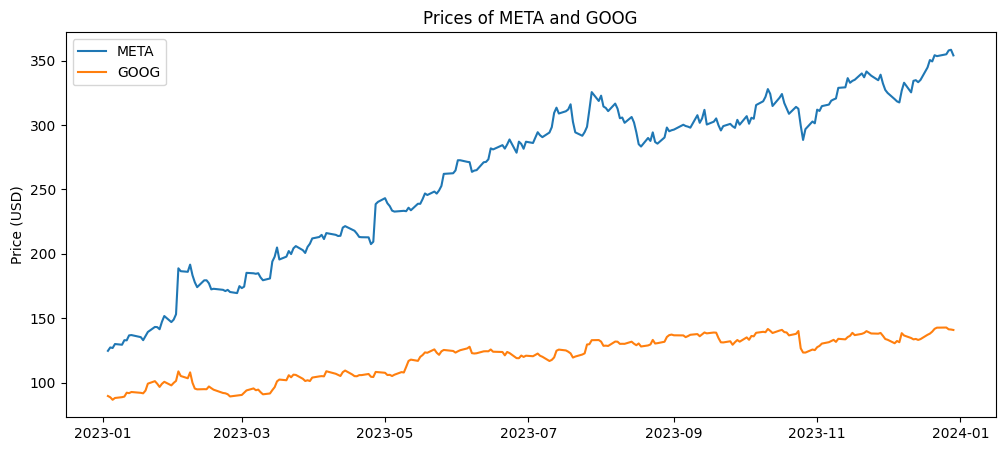

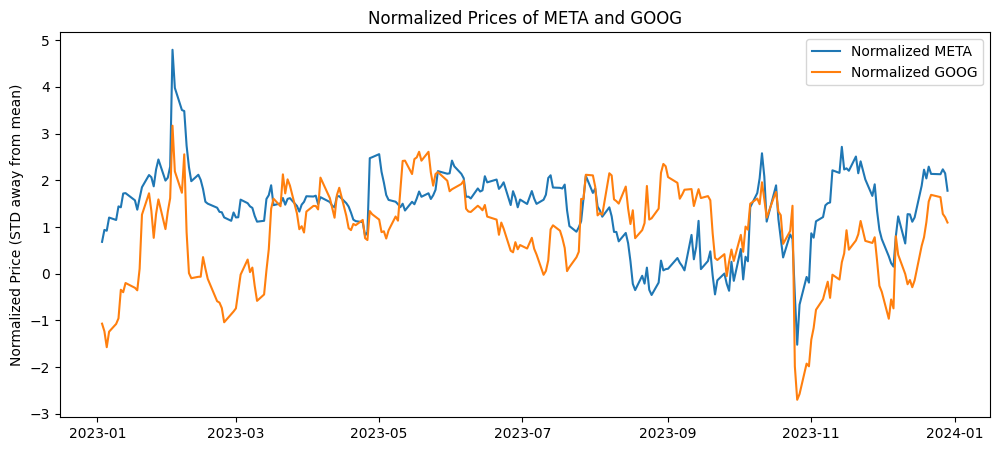

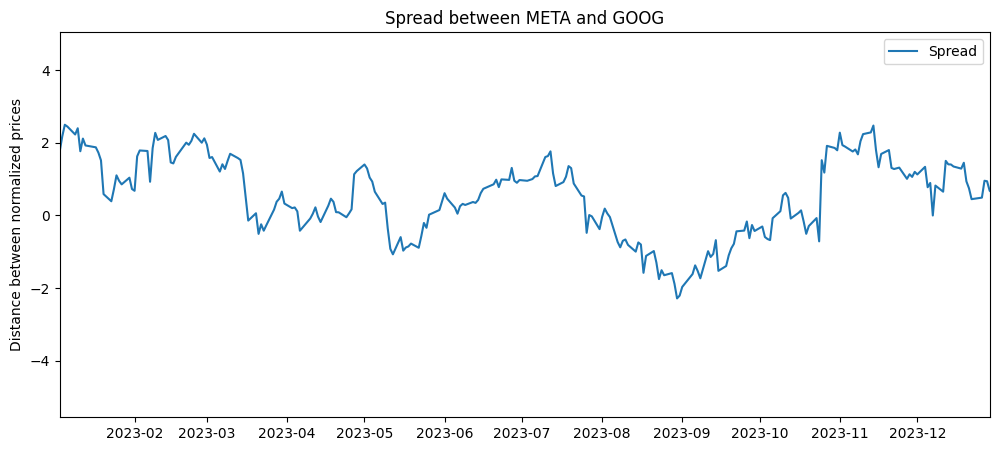

In [97]:
def normalization_visual_aid(df, ticker1, ticker2, pair_selection_beginning="2023-01-01", pair_selection_end="2023-12-31", window_size=60):
    '''
    This function only creates a couple visualizations that I use in the article,
    but it has no real meaning in the actual workflow of implementing stat arb
    '''
    # Converts dates to datetime
    pair_selection_beginning = pd.to_datetime(pair_selection_beginning)
    pair_selection_end = pd.to_datetime(pair_selection_end)
    df_copy = df.copy()

    # Calculates spread
    df_copy['spread'] = df_copy[f'normalized_{ticker1}'] - df_copy[f'normalized_{ticker2}']

    # Filters DataFrame for selected tickers and date range (plotting period)
    df_pair = df_copy.loc[(df_copy.index >= pair_selection_beginning) & (df_copy.index <= pair_selection_end),
                     [ticker1, f'normalized_{ticker1}', ticker2, f'normalized_{ticker2}', 'spread']]

    # Plots prices
    plt.figure(figsize=(12, 5))
    plt.plot(df_pair.index, df_pair[ticker1], label=ticker1)
    plt.plot(df_pair.index, df_pair[ticker2], label=ticker2)
    plt.title(f'Prices of {ticker1} and {ticker2}')
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

    # Plots normalized prices
    plt.figure(figsize=(12, 5))
    plt.plot(df_pair.index, df_pair[f'normalized_{ticker1}'], label=f'Normalized {ticker1}')
    plt.plot(df_pair.index, df_pair[f'normalized_{ticker2}'], label=f'Normalized {ticker2}')
    plt.title(f'Normalized Prices of {ticker1} and {ticker2}')
    plt.ylabel("Normalized Price (STD away from mean)")
    plt.legend()
    plt.show()

    # Plots spread with rolling mean
    plt.figure(figsize=(12, 5))
    plt.plot(df_copy.index, df_copy['spread'], label='Spread')
    plt.xlim(df_pair.index[0], df_pair.index[-1])
    plt.title(f'Spread between {ticker1} and {ticker2}')
    plt.ylabel("Distance between normalized prices")
    plt.legend()
    plt.show()

normalization_visual_aid(normalized_prices, 'META', 'GOOG')

## Step 3: Calculate zero-crossings and filter pairs

Why does zero-crossings make sense? It looks for stocks whose spread is constantly changing directions. To think about the problem with SSD, consider the entreme case where the spread between two stocks in nearly the same for the entire period of time (aka, they are parallel). In the original algorithm, this pair would be set as our favorite, but it does not allow us to actually trade.

In [98]:
def calculate_zero_crossings(data, tickers, pair_selection_beginning, pair_selection_end):
    """
    Calculates the number of zero crossings for pairs within the specified date range.
    The pairs are ordered by the
    highest number of zero crossings.
    """
    crossings_dict = {}

    # Filters the DataFrame based on the date range
    filtered_data = data.loc[pair_selection_beginning:pair_selection_end]

    # Generates pairs only involving 'V'
    ticker_pairs = itertools.combinations(tickers, 2)

    # Calculate zero crossings for each pair within the date range
    for ticker1, ticker2 in ticker_pairs:
        col1 = f"normalized_{ticker1}"
        col2 = f"normalized_{ticker2}"

        # Calculates the spread and counts zero crossings
        if col1 in filtered_data.columns and col2 in filtered_data.columns:
            spread = filtered_data[col1] - filtered_data[col2]
            zero_crossings = ((spread * spread.shift(-1)) < 0).sum()
            crossings_dict[(ticker1, ticker2)] = zero_crossings
        else:
          print('problem')

    # Prints output
    sorted_crossings_dict = dict(sorted(crossings_dict.items(), key=lambda item: item[1], reverse=True))
    print("Top pairs with highest zero crossings:")
    for i, (pair, crossings) in enumerate(sorted_crossings_dict.items()):
        print(f"{pair}: {crossings}")

calculate_zero_crossings(normalized_prices, tickers, pair_selection_beginning, pair_selection_end)

Top pairs with highest zero crossings:
('META', 'NVDA'): 36
('AMZN', 'NVDA'): 31
('AMZN', 'GOOG'): 30
('AMZN', 'META'): 30
('AMZN', 'NFLX'): 29
('META', 'NFLX'): 28
('AAPL', 'AMZN'): 26
('AAPL', 'NVDA'): 26
('GOOG', 'META'): 24
('GOOG', 'NVDA'): 24
('AAPL', 'NFLX'): 22
('NVDA', 'NFLX'): 21
('AAPL', 'META'): 20
('AAPL', 'GOOG'): 16
('GOOG', 'NFLX'): 14


In [74]:
def check_adf_and_spread_movements(df, ticker1, ticker2, pair_selection_beginning, pair_selection_end, window_size=60):
    '''
    Plots normalized prices and spread, and performs an ADF test on the spread.
    '''
    col1 = f"normalized_{ticker1}"
    col2 = f"normalized_{ticker2}"
    data = df.copy()
    pair_selection_beginning = pd.to_datetime(pair_selection_beginning)
    pair_selection_end = pd.to_datetime(pair_selection_end)

    if col1 not in data.columns or col2 not in data.columns:
        raise ValueError(f"The DataFrame must contain columns '{col1}' and '{col2}'.")

    data['spread'] = data[col1] - data[col2]
    data['spread_mean'] = data['spread'].rolling(window=window_size).mean().shift(1)
    data = data.loc[(data.index >= pair_selection_beginning) & (data.index <= pair_selection_end)]

    # Perform ADF test
    adf_result = adfuller(data['spread'].dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print("ADF Test Results:")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")
    print()

    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(data.index, data[col1], label=f'Normalized {ticker1}', color='blue', linewidth=2)
    axes[0].plot(data.index, data[col2], label=f'Normalized {ticker2}', color='orange', linewidth=2)
    axes[0].set_title(f"Normalized Prices: {ticker1} and {ticker2}", fontsize=16)
    axes[0].set_ylabel("Normalized Price", fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(alpha=0.3)

    axes[1].plot(data.index, data['spread'], label='Spread', color='green', linewidth=2)
    axes[1].plot(data.index, data['spread_mean'], color='black', linestyle='--', linewidth=2, label='Rolling Mean')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Line')
    axes[1].set_title(f"Spread (Normalized {ticker1} - {ticker2})", fontsize=16)
    axes[1].set_ylabel("Spread", fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


ADF Test Results:
ADF Statistic: -4.194612316169897
p-value: 0.0006728742439810362
Critical Values:
   1%: -3.4568881317725864
   5%: -2.8732185133016057
   10%: -2.5729936189738876



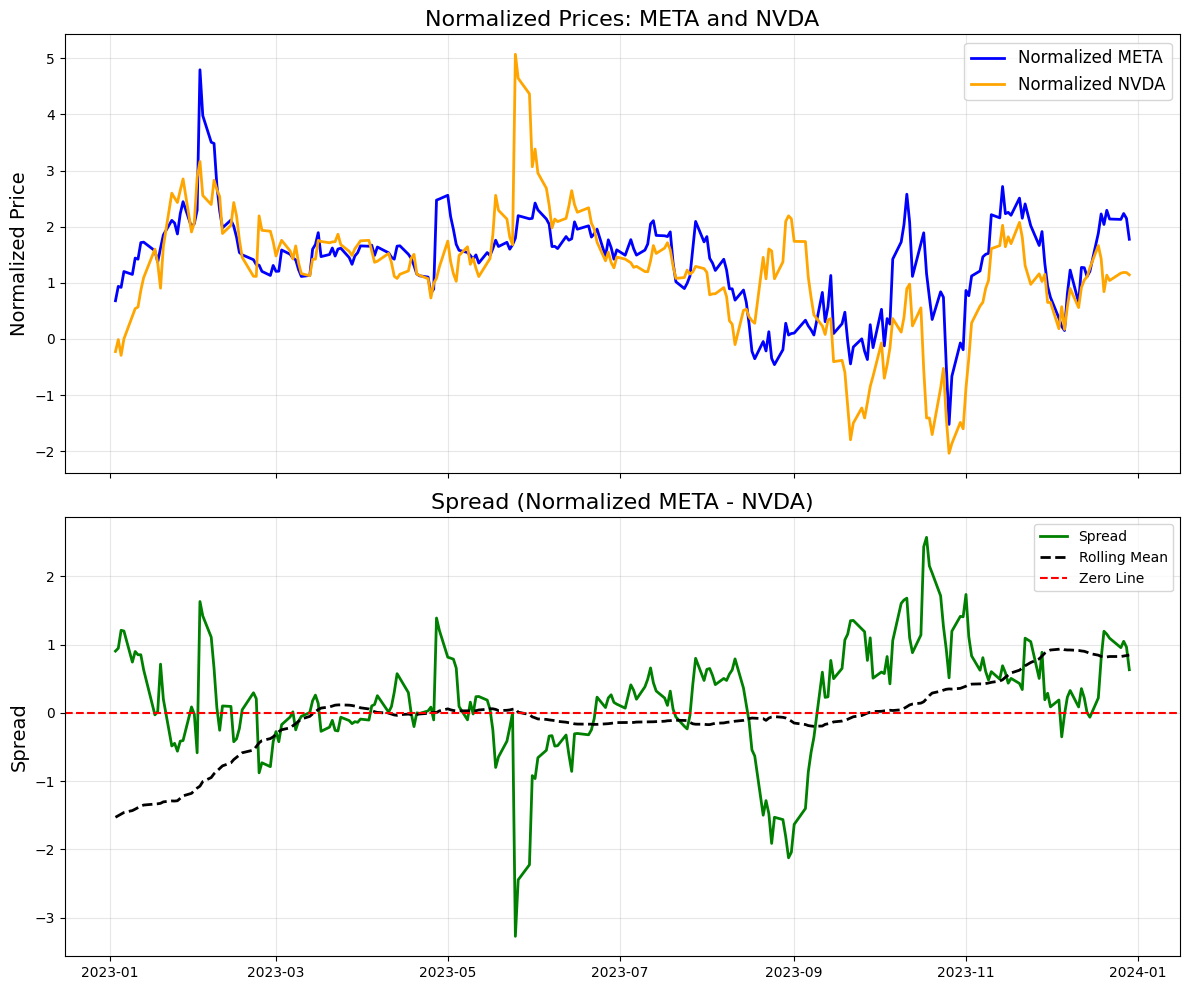

In [102]:
check_adf_and_spread_movements(normalized_prices, 'META', 'NVDA', pair_selection_beginning, pair_selection_end, window_size=60)

## Step 4: Evaluating movement activity

In [103]:
def plot_spread_activity(df, ticker1, ticker2, pair_selection_beginning, pair_selection_end, window_size=60):

    # Prepares data
    col1 = f"normalized_{ticker1}"
    col2 = f"normalized_{ticker2}"
    data = df.copy()
    pair_selection_beginning = pd.to_datetime(pair_selection_beginning)
    pair_selection_end = pd.to_datetime(pair_selection_end)

    if col1 not in data.columns or col2 not in data.columns:
        raise ValueError(f"The DataFrame must contain columns '{col1}' and '{col2}'.")

    # Calculates spread statistics and normalizes it
    data['spread'] = data[col1] - data[col2]
    data['spread_mean'] = data['spread'].rolling(window=window_size).mean().shift(1)
    data['spread_std'] = data['spread'].rolling(window=window_size).std().shift(1)
    data['normalized_spread'] = (data['spread'] - data['spread_mean']) / data['spread_std']

    data = data.loc[(data.index >= pair_selection_beginning) & (data.index <= pair_selection_end)]

    band_styles = {
        0.25: {'color': 'darkorange', 'linestyle': 'dotted'},
        0.5: {'color': 'navy', 'linestyle': 'dashdot'},
        1: {'color': 'sienna', 'linestyle': 'dashed'},
        2: {'color': 'darkblue', 'linestyle': 'solid'}
    }

    # Plots activity
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(data.index, data['spread'], label=f'Spread', color='green', linewidth=2)
    axes[0].plot(data.index, data['spread_mean'], color='black', linestyle='--', linewidth=2, label='Rolling Mean')

    for multiplier, style in band_styles.items():
        upper_band = data['spread_mean'] + (multiplier * data['spread_std'])
        lower_band = data['spread_mean'] - (multiplier * data['spread_std'])
        axes[0].plot(data.index, upper_band, color=style['color'], linestyle=style['linestyle'], linewidth=1.5,
                     label=f'Rolling Mean ± {multiplier}σ')
        axes[0].plot(data.index, lower_band, color=style['color'], linestyle=style['linestyle'], linewidth=1.5)

    axes[0].set_title(f"Spread: Normalized {ticker1} - {ticker2} (With Rolling Mean & Bands)", fontsize=16)
    axes[0].set_ylabel("Spread", fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)


    axes[1].plot(data.index, data['normalized_spread'], label='Normalized Spread', color='purple', linewidth=2)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5, label='Zero Line')

    for multiplier, style in band_styles.items():
        axes[1].axhline(multiplier, color=style['color'], linestyle=style['linestyle'], linewidth=1.5,
                         label=f'±{multiplier}σ')
        axes[1].axhline(-multiplier, color=style['color'], linestyle=style['linestyle'], linewidth=1.5)

    axes[1].set_title("Normalized Spread with Standard Deviation Bands", fontsize=16)
    axes[1].set_xlabel("Date", fontsize=14)
    axes[1].set_ylabel("Normalized Spread", fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


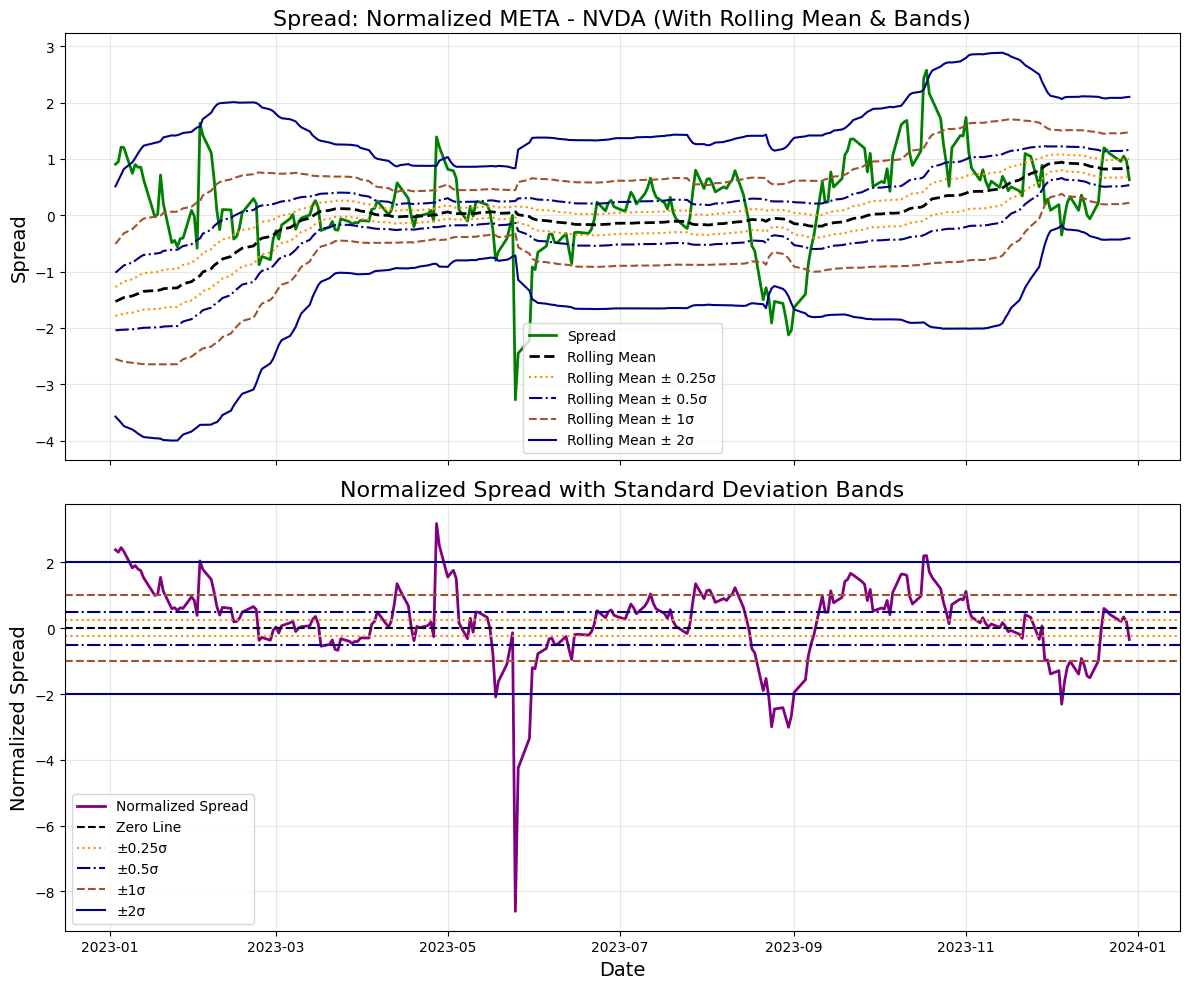

In [104]:
plot_spread_activity(normalized_prices, 'META', 'NVDA', pair_selection_beginning, pair_selection_end)

## Step 5: Backtest trading period

In [107]:
class Position:
  """
  Represents a trading position consisting of one stock shorted and another stock longed.
  """
  def __init__(self):
    self.stock_shorted = {'ticker': '', 'units': 0, 'price_purchase': 0, 'price_sale': 0}
    self.stock_longed = {'ticker': '', 'units': 0, 'price_purchase': 0, 'price_sale': 0}
    self.position_open = False
    self.open_date = None

  # Returns the status of position_open when we check for the object
  def __bool__(self):
    return self.position_open

  def open(self, row, invested_dollars, ticker1, ticker2):
    """
    Opens a long-short position based on the spread direction.

    Args:
      row (Series): Current market data row.
      invested_dollars (float): Total amount to invest in the trade.
      ticker1 (str): First ticker symbol.
      ticker2 (str): Second ticker symbol.
    """
    if row['spread'] > 0:
      winning_ticker, losing_ticker = ticker1, ticker2
    else:
      winning_ticker, losing_ticker = ticker2, ticker1

    # Short one stock and long the other:
    shorted_stock_units = invested_dollars*0.5 / row[f"{winning_ticker}"]
    longed_stock_units = invested_dollars*0.5 / row[f"{losing_ticker}"]
    self.stock_shorted = {'ticker': winning_ticker, 'units': shorted_stock_units, 'price_purchase': 0, 'price_sale': row[f"{winning_ticker}"]}
    self.stock_longed = {'ticker': losing_ticker, 'units': longed_stock_units, 'price_purchase': row[f"{losing_ticker}"], 'price_sale': 0}

    # Updates position status
    self.position_open = True
    self.open_date = row.name


  def close(self, row):
    '''
    Closes the position, calculates profit, and resets the position state.
    '''
    # Get stock prices at current day
    todays_price_longed_stock = row[self.stock_longed['ticker']]
    todays_price_shorted_stock = row[self.stock_shorted['ticker']]

    # Calculate profits
    revenue_long = (todays_price_longed_stock) * self.stock_longed['units']
    expense_short = (todays_price_shorted_stock) * self.stock_shorted['units']
    total_profit = revenue_long - expense_short

    # Resets loggers
    self.stock_shorted = {'ticker': '', 'units': 0, 'price_purchase': 0, 'price_sale': 0}
    self.stock_longed = {'ticker': '', 'units': 0, 'price_purchase': 0, 'price_sale': 0}
    self.position_open = False
    close_date = row.name

    #return total_profit
    return total_profit, self.open_date, close_date


class Strategy:
  '''
  Manages the trading strategy, including portfolio, trades, and performance evaluation.
  '''
  def __init__(self, initial_cash):
    self.cash = initial_cash
    self.greedy_position = Position()
    self.cautious_position = Position()
    self.trades = []
    self.portfolio_history = []
    self.cash_history = [initial_cash]
    self.exposure_log = []
    self.operation_log = []


  def open_position(self, type, row, ticker1, ticker2):
    '''
    Opens a cautious or greedy position based on spread signals.

    Args:
      type (str): "cautious" or "greedy".
      row (Series): Current market data row.
      ticker1 (str): First ticker symbol.
      ticker2 (str): Second ticker symbol.
    '''
    if type == 'cautious':
      investment_size = self.cash * 0.2
      self.cautious_position.open(row, investment_size, ticker1, ticker2)

    else:
      investment_size = self.cash * 0.4
      self.greedy_position.open(row, investment_size, ticker1, ticker2)

    # Log operation
    self.operation_log.append({'type': 'open_' + type, 'time': row.name, 'normalized_spread': row['normalized_spread']})


  def close_position(self, type, row):
    if type == 'cautious':
      profit, open_date, close_date = self.cautious_position.close(row)
    else:
      profit, open_date, close_date = self.greedy_position.close(row)

    self.cash += profit
    self.trades.append({'type': type, 'profit': profit, 'open_date': open_date, 'close_date': close_date})
    self.operation_log.append({'type': 'close_' + type, 'time': row.name, 'normalized_spread': row['normalized_spread']})


  def evaluate_portfolio(self, row):
    '''
    Evaluates and records current portfolio value including cash, assets, and liabilities.
    '''
    assets = 0
    liabilities = 0

    if self.greedy_position:
      ticker_longing, ticker_shorting = self.greedy_position.stock_longed['ticker'], self.greedy_position.stock_shorted['ticker']
      assets += self.greedy_position.stock_longed['units'] * row[ticker_longing]
      liabilities -= self.greedy_position.stock_shorted['units'] * row[ticker_shorting]

    if self.cautious_position:
      ticker_longing, ticker_shorting = self.cautious_position.stock_longed['ticker'], self.cautious_position.stock_shorted['ticker']
      assets += self.cautious_position.stock_longed['units'] * row[ticker_longing]
      liabilities -= self.cautious_position.stock_shorted['units'] * row[ticker_shorting]

    self.portfolio_history.append(self.cash + assets - liabilities)
    self.cash_history.append(self.cash)
    self.exposure_log.append(bool(self.greedy_position) or bool(self.cautious_position))

  def plot_operations(self, trading_df, greedy_threshold, cautious_threshold, stop_loss):
    '''
    Plots the normalized spread with markers for position openings and closings, and trade connections.

    Args:
      trading_df (DataFrame): Trading data with normalized spread.
      greedy_threshold (float): Greedy position threshold.
      cautious_threshold (float): Cautious position threshold.
      stop_loss (float): Stop loss threshold.
    '''

    # Extracting times and normalized spread for markers
    open_greedy = [op for op in self.operation_log if op['type'] == 'open_greedy']
    open_cautious = [op for op in self.operation_log if op['type'] == 'open_cautious']
    close_greedy = [op for op in self.operation_log if op['type'] == 'close_greedy']
    close_cautious = [op for op in self.operation_log if op['type'] == 'close_cautious']

    plt.figure(figsize=(16, 8))
    plt.plot(trading_df.index, trading_df['normalized_spread'], label='Spread', color='blue')

    # Plots events
    plt.scatter([op['time'] for op in open_greedy], [op['normalized_spread'] for op in open_greedy], label='Open Greedy', color='orange', marker='o')
    plt.scatter([op['time'] for op in open_cautious], [op['normalized_spread'] for op in open_cautious], label='Open Cautious', color='green', marker='o')
    plt.scatter([op['time'] for op in close_greedy], [op['normalized_spread'] for op in close_greedy], label='Close Greedy', color='purple', marker='x')
    plt.scatter([op['time'] for op in close_cautious], [op['normalized_spread'] for op in close_cautious], label='Close Cautious', color='black', marker='x')

    # Plots connecting lines between opens and closes
    for trade in self.trades:
        open_time = trade['open_date']
        close_time = trade['close_date']

        # Find normalized spread values at open and close
        open_spread = trading_df.loc[open_time, 'normalized_spread'] if open_time in trading_df.index else None
        close_spread = trading_df.loc[close_time, 'normalized_spread'] if close_time in trading_df.index else None

        if open_spread is not None and close_spread is not None:
            plt.plot([open_time, close_time], [open_spread, close_spread], color='gray', linestyle='--', alpha=0.7)


    # Plots thresholds
    plt.axhline(greedy_threshold, linestyle='--', color='purple', label='Greedy Bounds')
    plt.axhline(-greedy_threshold, linestyle='--', color='purple')
    plt.axhline(cautious_threshold, linestyle='--', color='green', label='Cautious Bounds')
    plt.axhline(-cautious_threshold, linestyle='--', color='green')
    plt.axhline(stop_loss, linestyle='--', color='red', label='Stop Loss')
    plt.axhline(-stop_loss, linestyle='--', color='red')

    plt.title('Pairs Trading Operation Log', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Normalized Spread', fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

  def measure_results(self, trading_df, greedy_threshold, cautious_threshold, stop_loss):
    '''
    Calculates and prints key metrics for the strategy, and plots the operation log.
    '''
    # Profit
    final_cash = self.cash_history[-1]
    initial_cash = self.cash_history[0]
    print(f"Final balance: ${round(final_cash, 2)}")
    print(f"Profit during period: {round((final_cash/initial_cash - 1)*100, 2)}%")

    # Sharpe ratio
    daily_returns = np.diff(self.portfolio_history) / self.portfolio_history[:-1]
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns, ddof=1)
    print(f"Sharpe Ratio: {round(sharpe_ratio, 3)}")

    # Max drawdown
    pv = np.array(self.portfolio_history)
    rolling_max = np.maximum.accumulate(pv)
    drawdowns = pv / rolling_max - 1
    max_drawdown = drawdowns.min()
    print(f"Max Drawdown: {round(max_drawdown * 100, 2)}%")

    # Win rate and averagr profit
    profits = [t['profit'] for t in self.trades]
    if profits:
      win_rate = sum(1 for p in profits if p > 0) / len(profits)
      avg_profit = np.mean(profits)
      print(f"Win Rate: {round(win_rate * 100, 2)}%")
      print(f"Average Profit per Trade: ${round(avg_profit, 2)}")
    else:
      print("No trades executed.")

    # Exposure ratio
    exposure_ratio = sum(self.exposure_log) / len(self.exposure_log)
    print(f"Exposure Ratio: {round(exposure_ratio * 100, 2)}%")
    print()

    # Plot operations
    self.plot_operations(trading_df, greedy_threshold, cautious_threshold, stop_loss)



In [92]:
def backtest_pair(df, ticker1, ticker2, initial_cash, trading_beginning, trading_end, greedy_threshold, cautious_threshold, stop_loss, window_size=30):
    '''
    Runs a backtest of a pairs trading strategy on two assets.

      The strategy operates on the normalized spread between two stocks:
      - Opens cautious or greedy positions based on threshold levels.
      - Closes positions when spread crosses the mean, changes direction, or exceeds stop-loss bounds.

      Args:
          df (DataFrame): DataFrame containing the historical stock prices and normalized prices.
          ticker1 (str): First stock ticker.
          ticker2 (str): Second stock ticker.
          initial_cash (float): Starting cash for the strategy.
          trading_beginning (str): Start date of the trading period.
          trading_end (str): End date of the trading period.
          greedy_threshold (float): Spread threshold to trigger greedy trades.
          cautious_threshold (float): Spread threshold to trigger cautious trades.
          stop_loss (float): Spread threshold to forcefully close positions to prevent excessive loss.
          window_size (int, optional): Window size for rolling mean and standard deviation of the spread. Default is 60.

      Returns:
          Strategy: Final Strategy object containing full trade logs, portfolio history, and metrics.
    '''

    # Preparing trading data
    col1 = f"normalized_{ticker1}"
    col2 = f"normalized_{ticker2}"
    data = df.copy()
    trading_beginning = pd.to_datetime(trading_beginning)
    trading_end = pd.to_datetime(trading_end)

    if col1 not in data.columns or col2 not in data.columns:
        raise ValueError(f"The DataFrame must contain columns '{col1}' and '{col2}'.")

    data['spread'] = data[col1] - data[col2]
    data['spread_mean'] = data['spread'].rolling(window=window_size).mean().shift(1)
    data['spread_std'] = data['spread'].rolling(window=window_size).std().shift(1)
    data['normalized_spread'] = (data['spread'] - data['spread_mean']) / data['spread_std']

    trading_df = data.loc[trading_beginning:trading_end]
    previous_spread = 0

    # Initialized trading strategy
    strategy = Strategy(initial_cash)

    # Main trading loop
    for index, row in trading_df.iterrows():
      spread = row['spread']
      normalized_spread = row['normalized_spread']

      # CASE 1: Close all positions if spread changes sign or if we go beyond the stop loss
      if (spread * previous_spread < 0) or (abs(normalized_spread) > stop_loss):
        if strategy.cautious_position.position_open:
          strategy.close_position('cautious', row)

        if strategy.greedy_position.position_open:
          strategy.close_position('greedy', row)

        # EOD operations
        strategy.evaluate_portfolio(row)
        previous_spread = spread


      # CASE 2: We are beyond the cautious threshold, but not on the stop loss yet.
      #   Open a cautious position hoping the spread will approach the mean again
      if (abs(normalized_spread) > cautious_threshold) and (abs(normalized_spread) < stop_loss):

        if not strategy.cautious_position.position_open:
          strategy.open_position("cautious", row, ticker1, ticker2)

        # EOD operations
        strategy.evaluate_portfolio(row)
        previous_spread = spread

      # CASE 3: Spread is in between cautious and greedy bounds
      #   We close a cautious position, if there's any open, and open a greedy position, assuming spread will regress even more to the mean
      elif abs(normalized_spread) > greedy_threshold and abs(normalized_spread) < cautious_threshold:
        if strategy.cautious_position.position_open:
          strategy.close_position('cautious', row)

        if not strategy.greedy_position.position_open:
          strategy.open_position("greedy", row, ticker1, ticker2)

        # EOD operations
        strategy.evaluate_portfolio(row)
        previous_spread = spread

      # CASE 4: Spread is below greedy threshold, which means it is super close to the mean
      #   Close all positions
      elif abs(normalized_spread) < greedy_threshold:
        if strategy.cautious_position.position_open:
          strategy.close_position('cautious', row)

        if strategy.greedy_position.position_open:
          strategy.close_position('greedy', row)

        # EOD operations
        strategy.evaluate_portfolio(row)
        previous_spread = spread


   # At the end of the trading period, close any open positions
    if strategy.cautious_position.position_open:
          strategy.close_position('cautious', row)

    if strategy.greedy_position.position_open:
      strategy.close_position('greedy', row)

    # EOD operations
    strategy.evaluate_portfolio(row)
    previous_spread = spread

    # Show final results
    strategy.measure_results(trading_df, greedy_threshold, cautious_threshold, stop_loss)

    return strategy

Final balance: $11663.66
Profit during period: 16.64%
Sharpe Ratio: 0.089
Max Drawdown: -45.37%
Win Rate: 70.18%
Average Profit per Trade: $29.19
Exposure Ratio: 65.47%



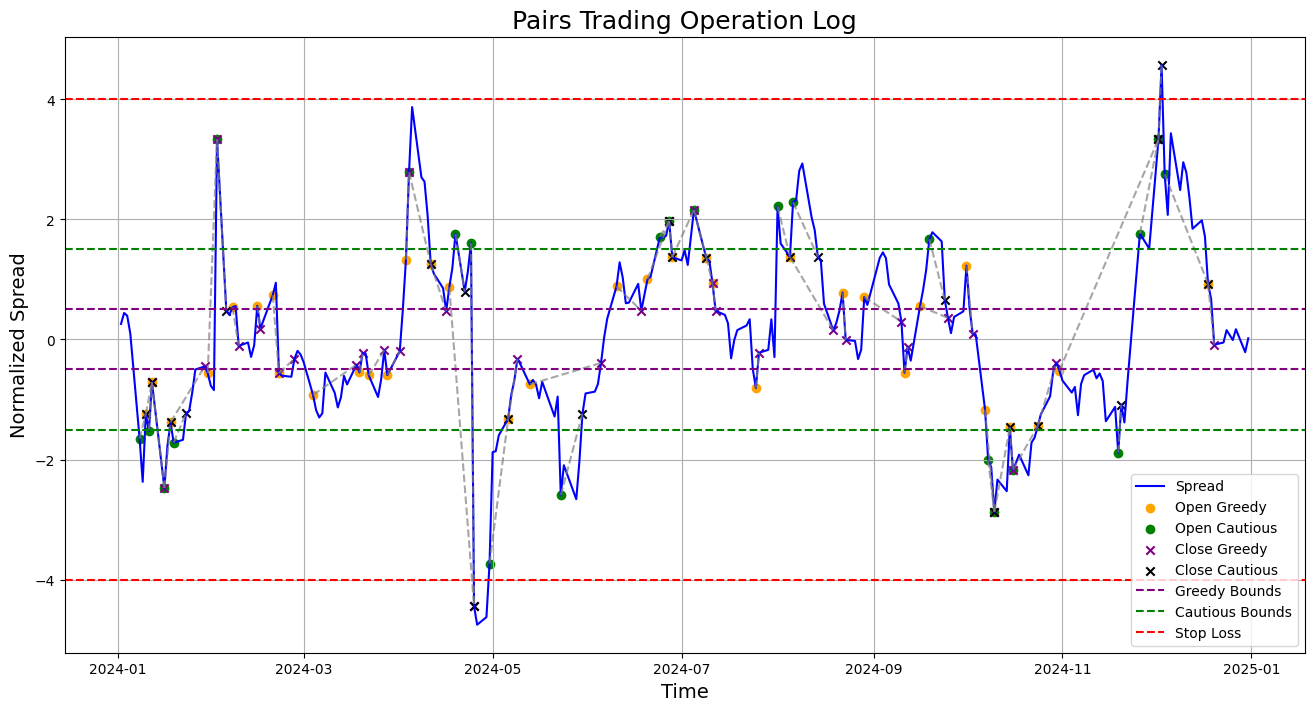

In [108]:
greedy_threshold = 0.5
cautious_threshold = 1.5
stop_loss = 4

strategy = backtest_pair(normalized_prices, 'META', 'NVDA', 10000, trading_beginning, trading_end, greedy_threshold, cautious_threshold, stop_loss, window_size=30)